# Example using KARS (Kernel Approximation of Raman Spectra)

First, we read in some example library data

In [1]:
import kars

In [2]:
import pandas as pd
import numpy as np

library_params = pd.read_csv('params.csv',header=None) #gas parameters
library_params.columns = ['Temp','N2','H2','O2','H2O']

library = pd.read_csv('spectra.csv',header=None).T #library spectra
library = np.sqrt(library)

library_wns = pd.read_csv('wn.csv',header=None).T #wavenumber (not strictly nec.)
w = np.array(library_wns.iloc[0])

we'll split off some of the example data into a validation set and keep some for training

In [3]:
n_train = 750

In [4]:
np.random.seed(65441326)
train_params, val_params, train_ls, val_ls, _, _ = kars.split_data(library_params,library,
                                                        n_train = n_train)

make the kars fit

In [5]:
kf = kars.karsft(train_params = train_params,
           train_ls = train_ls,
           gamma=1)

we can then look at some predictions of the validation data. First we look at predicting a single spectra,

In [6]:
from matplotlib import pyplot as plt

In [7]:
truth = val_ls.iloc[0]
pm = np.array([val_params.iloc[0]])

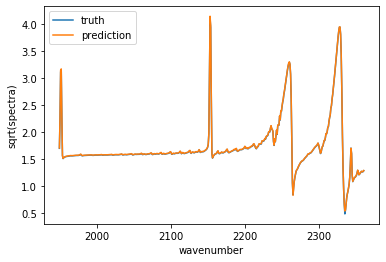

In [8]:
pred = kf.predict(pm).reshape(-1)
plt.plot(w,truth,label='truth');
plt.plot(w,pred,label='prediction')
plt.legend();
plt.xlabel("wavenumber");
plt.ylabel("sqrt(spectra)");

but we can also predict multiple spectra at a time,

In [9]:
truth = val_ls.iloc[0:3].T
pm = val_params.iloc[0:3]

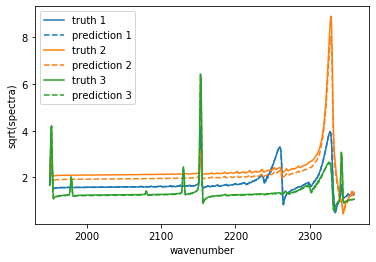

In [10]:
clr_cycle = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
pred = kf.predict(pm).T

for i in range(pred.shape[1]):
    plt.plot(w,truth.iloc[:,i],linestyle='solid',label='truth '+str(i+1),color=clr_cycle[i]);
    plt.plot(w,pred[:,i],linestyle='dashed',label='prediction '+str(i+1),color=clr_cycle[i]);

plt.xlabel("wavenumber");
plt.ylabel("sqrt(spectra)");
plt.legend();

given our kars fit we can see which validation spectra it predicts worst

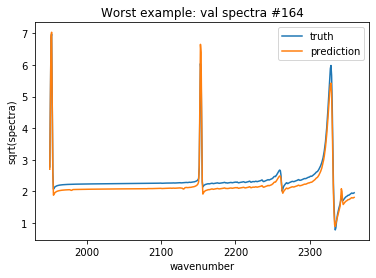

In [11]:
dff = (kf.predict(val_params) - val_ls)
ii = np.argmax(np.max(dff,axis=1))
truth = val_ls.iloc[ii]
pm = np.array([val_params.iloc[ii]])
pred = kf.predict(pm).reshape(-1)
plt.plot(w,truth,label='truth');
plt.plot(w,pred,label='prediction')
plt.title("Worst example: val spectra #"+str(ii))
plt.xlabel("wavenumber");
plt.ylabel("sqrt(spectra)");
plt.legend();

We can improve the fit by choosing $\gamma$ with cross validation. First we set some range of $\gamma$ values to try out

In [12]:
gma_seq = [10**float(x) for x in np.arange(-5,5,2)]

and then we calculate the cross-validated error using only the training data

In [13]:
xv_err = kars.xv_gamma(gma_seq,tpms=train_params,tls=train_ls)

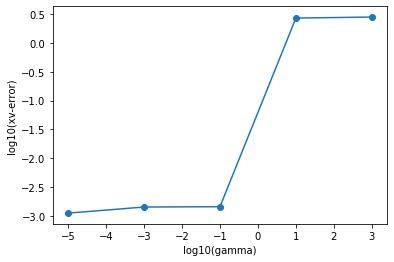

In [14]:
plt.scatter(np.log10(gma_seq),np.log10(xv_err));
plt.plot(np.log10(gma_seq),np.log10(xv_err));
plt.xlabel("log10(gamma)");
plt.ylabel("log10(xv-error)");

we then choose $\gamma^*$ as the value which minimizes this cross-validated error

In [15]:
gma_star = gma_seq[np.argmin(xv_err)]
gma_star

1e-05

and re-fit our kars fit using this value

In [16]:
kf = kars.karsft(train_params = train_params,
           train_ls = train_ls,
           gamma=gma_star)

we can now look at this worst example again and see improvement 

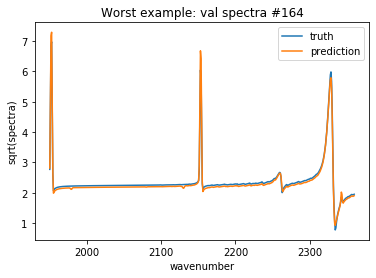

In [17]:
dff = (kf.predict(val_params) - val_ls)
ii = np.argmax(np.max(dff,axis=1))
truth = val_ls.iloc[ii]
pm = np.array([val_params.iloc[ii]])
pred = kf.predict(pm).reshape(-1)
plt.plot(w,truth,label='truth');
plt.plot(w,pred,label='prediction')
plt.title("Worst example: val spectra #"+str(ii))
plt.xlabel("wavenumber");
plt.ylabel("sqrt(spectra)");
plt.legend();